In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import UnaryLinear
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def linear_test(rng="Sobol", in_feature=128, out_feature=10000, bitwidth=8, bias=True):
    modes = ["bipolar", "unipolar"]
    scaled = [True, False]
    result_pe = []
    
    for mode in modes:
        for scale in scaled:
            length = 2**bitwidth
            result_pe_cycle = []
            fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)
            
            if mode is "unipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(length).round().div(length).to(device)
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(length).round().div(length).to(device)
            elif mode is "bipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(2).sub(1).mul(length).round().div(length).to(device)
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(2).sub(1).mul(length).round().div(length).to(device)

            ufc = UnaryLinear(in_feature, out_feature, fc.weight, fc.bias, 
                              bitwidth=bitwidth, mode=mode, scaled=scale, bias=bias).to(device)

            iVec = ((torch.rand(1, in_feature)*length).round()/length).to(device)
            oVec = fc(iVec)

            if scale is False:
                oVec = oVec.clamp(-1.,1.).mul(length).floor()/length
            else:
                if bias is True:
                    oVec = oVec.div(in_feature+1).mul(length).floor()/length
                else:
                    oVec = oVec.div(in_feature).mul(length).floor()/length

            iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode)().to(device)
            iVecRNG = RNG(bitwidth, 1, rng)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG).to(device)

            iVecPE = ProgressiveError(iVec, mode=mode).to(device)
            oVecPE = ProgressiveError(oVec, mode=mode).to(device)

            with torch.no_grad():
                idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                start_time = time.time()
                for i in range(length):
                    iBS = iVecBS(idx + i)
                    iVecPE.Monitor(iBS)

                    oVecU = ufc(iBS)
                    oVecPE.Monitor(oVecU)
                    if bias is False:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                    else:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/(out_feature+1)).item())
                print("--- %s seconds ---" % (time.time() - start_time))
                print("input error: ", "min:", torch.min(iVecPE()[1]).item(), "max:", torch.max(iVecPE()[1]).item())
                print("output error: ", "min:", torch.min(oVecPE()[1]).item(), "max:", torch.max(oVecPE()[1]).item(), "RMSE: ", torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                result_pe = oVecPE()[1][0].cpu().numpy()
                print("error distribution=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                print("progressive accuracy=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.plot(result_pe_cycle)  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                

--- 1.4379997253417969 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.0078125 max: 0.0 RMSE:  0.004705855622887611
error distribution=========>


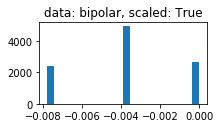

progressive accuracy=========>


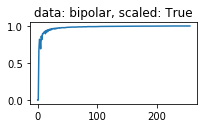

--- 1.3929996490478516 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.32421875 max: 0.125 RMSE:  0.3288794159889221
error distribution=========>


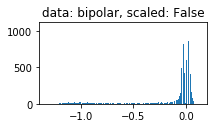

progressive accuracy=========>


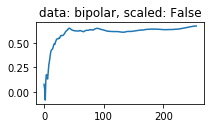

--- 0.7559995651245117 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.00390625 max: 0.0 RMSE:  0.0023654592223465443
error distribution=========>


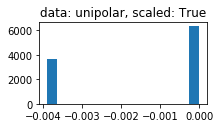

progressive accuracy=========>


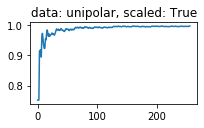

--- 0.7630000114440918 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


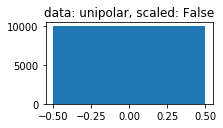

progressive accuracy=========>


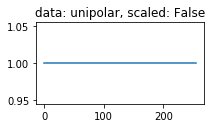

In [10]:
rng = "Sobol"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 1.3880019187927246 seconds ---
input error:  min: -0.01171875 max: 0.00390625
output error:  min: -0.0078125 max: 0.0 RMSE:  0.004803099203854799
error distribution=========>


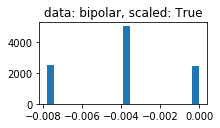

progressive accuracy=========>


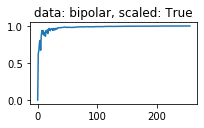

--- 1.2739982604980469 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.2734375 max: 0.3359375 RMSE:  0.320432186126709
error distribution=========>


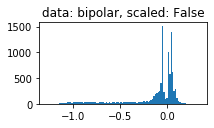

progressive accuracy=========>


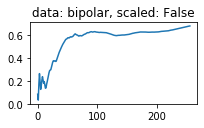

--- 0.7420005798339844 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.00390625 max: 0.0 RMSE:  0.002848082222044468
error distribution=========>


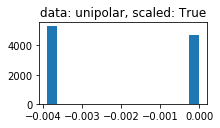

progressive accuracy=========>


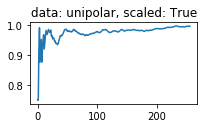

--- 0.7380006313323975 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


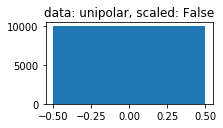

progressive accuracy=========>


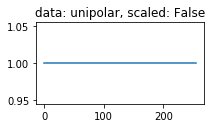

In [11]:
rng = "LFSR"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 1.0510001182556152 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.0078125 max: 0.0 RMSE:  0.004614503122866154
error distribution=========>


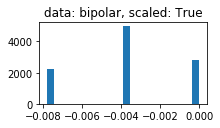

progressive accuracy=========>


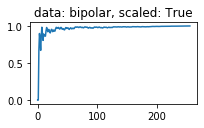

--- 0.9529993534088135 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.8984375 max: 1.5859375 RMSE:  0.5549200773239136
error distribution=========>


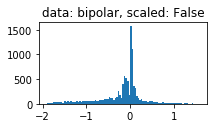

progressive accuracy=========>


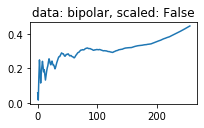

--- 0.6399998664855957 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.00390625 max: 0.0 RMSE:  0.0024366360157728195
error distribution=========>


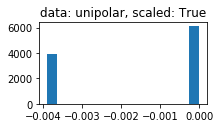

progressive accuracy=========>


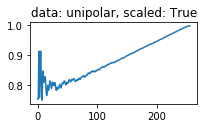

--- 0.7089989185333252 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


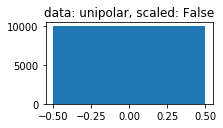

progressive accuracy=========>


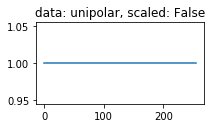

In [12]:
rng = "Race"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 1.5470001697540283 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.0078125 max: 0.0 RMSE:  0.004678865894675255
error distribution=========>


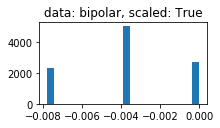

progressive accuracy=========>


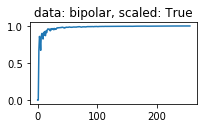

--- 1.4190003871917725 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.5 max: 0.203125 RMSE:  0.3510240614414215
error distribution=========>


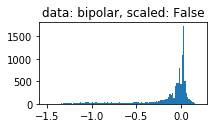

progressive accuracy=========>


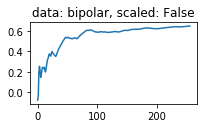

--- 0.8179993629455566 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.00390625 max: 0.0 RMSE:  0.002475157380104065
error distribution=========>


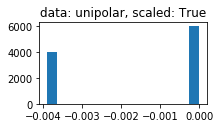

progressive accuracy=========>


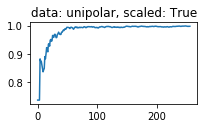

--- 0.8200016021728516 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


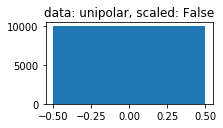

progressive accuracy=========>


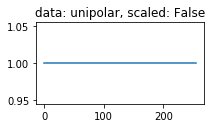

In [13]:
rng = "SYS"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)